In [1]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import clmm.polaraveraging as pa
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import fnmatch
from scipy.integrate import quad
import pickle 

import iminuit
from iminuit import Minuit

sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')

import statistics_ as stat
import modeling as model
#import modeling_test as model
import utils as ut
import perform_stacking as stack_in_bin
import resampling
from scipy import interpolate

sys.path.append('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Analysis/cosmoDC2/Fit_Halo_Mass/Fit_Cluster_Lensing_Mass/Run_Python_Codes')

import settings_analysis as settings

In [2]:
################################################################################################
cosmo = settings.cosmo

Richness_bin, Mass_bin, Z_bin = settings.Richness_bin, [[1*1e14, 1.2*1e14]], [[0.3,0.4]]

Choose_binning = 'M_fof'

is_deltasigma = True

################################################################################################
Mass_def = 'mean'

#signal = model.Signal(cosmo = cosmo)
#signal._set_halo_def(mass_def = Mass_def, delta_mdef = 200, halo_profile_model = 'einasto')
#signal._set_is_deltasigma(is_deltasigma = True)
#signal.available_parameters()
#signal._set_free_parameters(free_logm = True, free_concentration = True)
##############################################################################################

where_catalogs =settings.path_cosmoDC2

if Choose_binning == 'M_fof': Binning_your_data = Mass_bin
elif Choose_binning == 'richness': Binning_your_data = Richness_bin

## Defining Stacked cluster catalog

In [3]:
for obs_bin in Binning_your_data:
    
    for z_bin in Z_bin:
        
        r"""
        Definning stacking signal
        """
        
        stack = stack_in_bin.Perform_Stacking(is_deltasigma = True, cosmo = cosmo)
        
        try : 
            
            stack._check_available_catalogs(bin_def = Choose_binning, 
                                            z_bin = z_bin, 
                                            obs_bin = obs_bin, 
                                            where_source = where_catalogs, 
                                            r_lim = 5)
        
        except ValueError: continue
            
        cl = stack.make_GalaxyCluster_catalog()
        
        stack.add_weights(cl)
        
        stack._check_average_inputs()

n = there are 151 available catalogs


In [4]:
down, up, n_bins = 0.2 , 5 , 20

In [5]:
bin_edges = pa.make_bins( down , up , n_bins , method = 'evenlog10width')
profile = stack.make_binned_profile(cl = cl, bin_edges = bin_edges)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/perform_stacking.py:313: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  profile['gal_id'] = np.array(gal_id)
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/perform_stacking.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  profile['halo_id'] = np.array(halo_id)
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/perform_stacking.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

# Estimating individual profile

In [6]:
p_individual_t = []
p_individual_x = []
for i in range(cl.n_stacked_catalogs):
    cl_individual = stack.list_cl[i]
    stack.add_weights(cl_individual)
    profile_ = stack.make_binned_profile(cl = cl_individual, bin_edges = bin_edges)
    p_individual_t.append([profile_['radius'],profile_['gt']])
    p_individual_x.append([profile_['radius'],profile_['gx']])

In [7]:
cov_t_sample, cov_x_sample = stack.sample_covariance(bin_edges = bin_edges)

In [8]:
#plt.plot(profile['radius'],profile['gt']/np.sqrt(cov_t_sample.diagonal()), 'k')
#plt.xlim(profile['radius'][0], profile['radius'][-1])
#plt.xscale('log')
#plt.ylabel(r'$S/N$')
#plt.xlabel('R [Mpc]')
#plt.legend(frameon = False)
#os.chdir('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3')
#plt.savefig('sample_cov.png', bbox_inches='tight', dpi=300)

# Estimating Bootstrap covariance matrix

In [9]:
cov_t_bootstrap, cov_x_bootstrap = stack.bootstrap_resampling(binned_profile = profile, catalog = cl, n_boot = 100)

In [10]:
#for n_jk in [10,20,30,40,50,60]:
    
#    cov_t_jack, cov_x_jack = jacknife_resampling(profile, n_jk)

#    plt.plot(profile['radius'],profile['gt']/np.sqrt(cov_t_jack.diagonal()), label = f'n_jk = {n_jk}')
    
#plt.plot(profile['radius'],profile['gt']/np.sqrt(cov_t_bootstrap.diagonal()), '--k', label = 'bootstrap')
#plt.plot(profile['radius'],profile['gt']/np.sqrt(cov_t_sample.diagonal()), '-*', label = 'sample covariance')
#plt.xscale('log')
#plt.xlim(profile['radius'][0], profile['radius'][-1])
#plt.ylabel(r'$\sqrt{Cov(R_i, R_i)}$')
#plt.ylabel(r'$S/N$')
#plt.xlabel('R [Mpc]')
#plt.legend(frameon = False)
#os.chdir('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3')
#plt.savefig('jk_boot_err.png', bbox_inches='tight', dpi=300)

In [11]:
cov_t = cov_t_bootstrap
cov_x = cov_x_bootstrap

In [12]:
profile['gt_err'] = np.sqrt(cov_t.diagonal())
profile['gx_err'] = np.sqrt(cov_x.diagonal())

# DEFINNING MODEL

In [13]:
cluster_z = stack.z
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'einasto')
moo.set_cosmo(cosmo)


In [14]:
#def predict_excess_surface_density(r, logm):
    
#    c = model.Duffy_concentration(10.**logm, cluster_z, 'mean')

#    m = 10.**logm 
    
#    moo.set_mass(m) 
    
#    moo.set_concentration(c)
    
#    deltasigma = []
    
#    for i, R in enumerate(r):
        
#        surface_density = moo.eval_sigma_excess(R, cluster_z)
    
#        deltasigma.append(surface_density)
        
#    return deltasigma


In [15]:
r_lim = max(0.5*stack.z + 0.50, down)

index = np.arange(len(profile['radius']))

mask = profile['radius'] > r_lim

index_mask = index[mask]

#r_lim = max(1.15 * stack.z + 0.50, down)

R = profile['radius'][mask]

y_exp = profile['gt'][mask]

n = len(mask[mask == True])

In [16]:
cov_fit = np.zeros((n,n))
for i in range(n):
    index_1 = index_mask[i]
    for j in range(n):
        index_2 = index_mask[j]
        cov_fit[i,j] = cov_t[index_1, index_2]

In [17]:

#plt.plot(R,np.sqrt(cov_fit.diagonal()),'k')
#plt.plot(profile['radius'],np.sqrt(cov_t_bootstrap.diagonal()),'--g')

In [18]:
bins = np.array([[bin_edges[i], bin_edges[i + 1]] for i in range(len(bin_edges) - 1)])
mask = profile['radius'] > r_lim
bins = bins[mask]

In [19]:
def predict_excess_surface_density(r, logm, c):
    
   # c = model.Duffy_concentration(10.**logm, cluster_z, 'mean')

    m = 10.**logm 
    
    moo.set_mass(m) 
    
    moo.set_concentration(c)
    
    deltasigma = []
    
    r"""
    
    def f(R) : return moo.eval_sigma_excess(R, cluster_z) * R * 2 * np.pi
    
    for i, R in enumerate(r):
        
        S = np.pi * bins[i][1]**2 - np.pi * bins[i][0]**2
        
        surface_density = quad(f,bins[i][0], bins[i][1])[0] / S
    
        deltasigma.append(surface_density)
        
    """
    for i, R in enumerate(r):
    
        deltasigma.append(moo.eval_sigma_excess(R, cluster_z))
        
    return np.array(deltasigma)

In [20]:
def chi2(logm,c):
    
    chi2 = 0
    
    inv_cov = np.linalg.inv(np.diag(np.diag(cov_fit)))
    
    y_predict = predict_excess_surface_density(R, logm,c)
    
    for i, r in enumerate(R):
        
        for j, rprime, in enumerate(R):
            
            chi2 += (y_predict[i] - y_exp[i])*inv_cov[i,j]*(y_predict[j] - y_exp[j])

    return chi2

In [21]:
#m = Minuit.from_array_func(chi2, (13,1,0.1), errordef = 0.5)

m = Minuit(chi2, logm = 13,c = 4, limit_logm = (11,16),limit_c = (0,20), errordef = 1)

m.migrad()

m.hesse()

m.minos()

chi2min_dof =  m.fval/(n_bins-1)

print(m.params)


┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ logm │  14.124   │   0.011   │   -0.011   │   0.011    │   11    │   16    │       │
│ 1 │ c    │    4.1    │    0.4    │    -0.4    │    0.4     │    0    │   20    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [22]:
m.fval/(len(y_exp)-1)


0.8852340472014825

In [23]:
model.Duffy_concentration(10**m.values['logm'], cluster_z, 'mean')

5.465035281808341

In [24]:
mass = 10**m.values['logm']

In [25]:
err_mass = np.log(10)*mass*(m.errors['logm'])

In [26]:
print(f'{mass:.2e} pm {err_mass:.2e}')

1.33e+14 pm 3.31e+12


In [27]:
def myyticks(x,pos):
    if x == 0: return "$0$"

    sign = x/abs(x)
    coeff = (x)/10**13

    return r"${:2.1f}$".format(coeff)

def myxticks(x,pos):
    if x == 0: return "$0$"

    exponent = int(np.log10(abs(x)))
    sign = x/abs(x)
    coeff = (x/(10**exponent))

    
    return r"${:.1f}$".format(x)

In [28]:
r = profile['radius']
R = r[r > r_lim]

In [29]:
rr = np.linspace(0.1,10,100)
gt, gt_err = profile['gt'], profile['gt_err']
gx, gx_err = profile['gx'], profile['gx_err']
#y_up = predict_excess_surface_density(R, m.values['logm'] + 3*m.merrors['logm'].upper, m.values['c'] + 3*m.merrors['c'].upper)
#y_down = predict_excess_surface_density(R, m.values['logm'] + 3*m.merrors['logm'].lower,  m.values['c'] + 3*m.merrors['c'].lower)
y = predict_excess_surface_density(R, m.values['logm'], m.values['c'])

In [30]:
y_up = []
y_down = []

for i, r_ in enumerate(R):
    
    def shear(p): 
        
        return predict_excess_surface_density([r_], p[0], p[1])[0]
    
    def shear_(p): return -shear(p)
    
    bounds = [(m.values['logm'] - 1*m.errors['logm'],m.values['logm'] + 3*m.errors['logm']),
              (m.values['c'] - 1*m.errors['c'],m.values['c'] + 3*m.errors['c'])]

    from scipy.optimize import fmin_tnc

    logm_min, c_min = fmin_tnc(shear, np.array([m.values['logm'],m.values['c']]), approx_grad = True, bounds = bounds)[0]
    logm_max, c_max = fmin_tnc(shear_, np.array([m.values['logm'],m.values['c']]), approx_grad = True, bounds = bounds)[0]
    
    y_up.append(shear([logm_max, c_max]))
    y_down.append(shear([logm_min, c_min]))
    
    

In [31]:
y_up = np.array(y_up)
y_down = np.array(y_down)

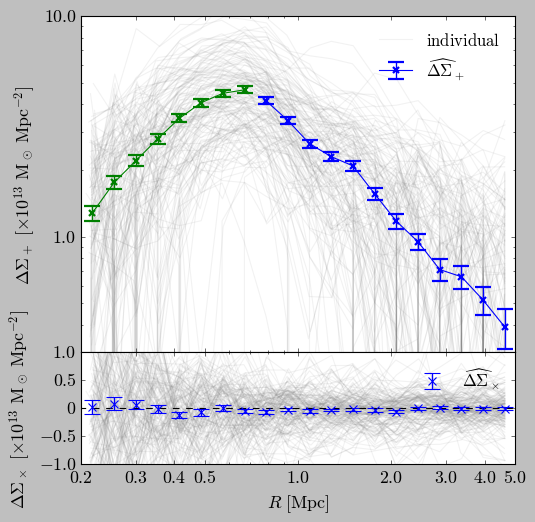

In [39]:
from matplotlib import gridspec
import matplotlib.ticker as ticker
plt.style.use('classic')

ylabelup = r'$\Delta\Sigma_+$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
ylabeldown = r'$\Delta\Sigma_\times$ ' +'$[$' + r'$\times 10^{13}$ ' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$'
xlabel = r'$R\ [$' + r'${\rm Mpc}$' + r'$]$'

# Simple data to display in various forms

fig = plt.figure(figsize = (7,7))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.tick_params(axis='both', which='major', labelsize=16)
ax0.set_ylabel(ylabelup, fontsize=16)
#ax0.set_ylabel('r'$\rm{stacked}\ \Delta\Sigma_\times$)

# log scale for axis Y of the first subplot
ax0.set_yscale("log")
ax0.set_xscale("log")
#ax0.set_xlim(down, up)
ax0.set_ylim(3*10**12, 1*10**14)

#ax0.fill_between(R, y_up , y_down ,color = 'r', alpha = 1)
#ax0.plot(R,y ,'-k', alpha = 1, label=r'$\rm{best\ fit\ NFW}$')
line0 = ax0.errorbar(profile['radius'][profile['radius']>r_lim], gt[profile['radius']>r_lim],gt_err[profile['radius']>r_lim],fmt='-x',capsize = 7 ,ecolor = 'b',elinewidth=1.2, c='b',
                     markeredgecolor='b',markerfacecolor='None',markeredgewidth=2,label=r'$\widehat{\Delta\Sigma}_+$')
line0 = ax0.errorbar(profile['radius'][profile['radius']<r_lim], gt[profile['radius']<r_lim],gt_err[profile['radius']<r_lim],fmt='-x',capsize = 7 ,ecolor = 'g',elinewidth=1.2, c='g',
                     markeredgecolor='g',markeredgewidth=2,markerfacecolor='None')

ax0.plot([],[], c='grey', alpha = 0.1,label=r'$\rm{individual}$')

for p_ in p_individual_t:
    
    ax0.plot(p_[0],p_[1],'-',c='grey',alpha=0.1,zorder = 0)

ax0.yaxis.set_major_formatter(ticker.FuncFormatter(myyticks))
ax0.legend(loc='best', frameon = False,
          numpoints = 1, fontsize = 15)

##############################
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlabel(xlabel, fontsize=16)
ax1.set_ylabel(ylabeldown, fontsize=16)

line1 = ax1.errorbar(profile['radius'], gx,gx_err, label=r'$\widehat{\Delta\Sigma}_\times$'\
                    ,fmt='x',capsize = 7 ,ecolor = 'b',elinewidth=1.2, c='b',\
                 markeredgecolor='b',markerfacecolor='None',markeredgewidth=1, markersize = 8)


ax1.plot(rr, 0*rr, '--k')
ax1.legend(loc='upper right', frameon = False,
          numpoints = 1, fontsize = 15)

for p_ in p_individual_x:
    
    ax1.plot(p_[0],p_[1],'-',c='grey',alpha=0.1,zorder = 0)
 

plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot

yticks = ax1.yaxis.get_major_ticks()
ax1.set_xticks([0.2,0.3,0.4,0.5,1,2,3,4,5])
yticks[-1].label1.set_visible(False)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(myyticks))
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(myxticks))
ax1.set_xlim(down, up)
ax1.set_ylim(-1*10**13, 1*10**13)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.0)


os.chdir('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3')

plt.savefig('DeltaSigma_Stacking.png', bbox_inches='tight', dpi=300)

plt.show()

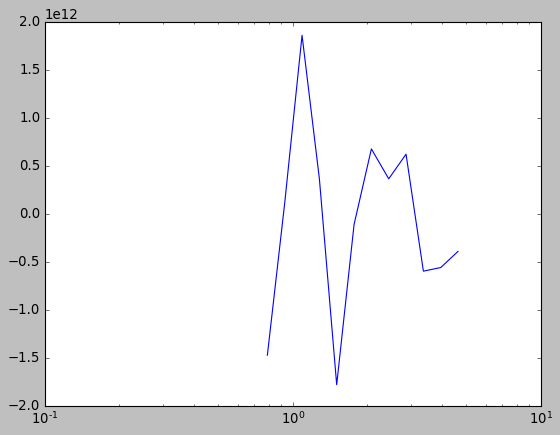

In [33]:
plt.plot(R,y-y_exp)
plt.xscale('log')